# All_Data_Morrisons TimeSeriesForecasting

# Load Data

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(
    '/kaggle/input/time-series-uk-supermarket-data/All_Data_Morrisons.csv',
    parse_dates=['date'])

df.head()

,supermarket,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,Morrisons,2.10,4.20,kg,Alpro Vanilla Yoghurt Alternative,2024-04-13,free-from,False
1,Morrisons,2.10,4.20,kg,Alpro Plain No Sugars Yoghurt Alternative,2024-04-13,free-from,False
2,Morrisons,2.30,2.30,l,Alpro Barista Coconut Milk,2024-04-13,free-from,False
3,Morrisons,3.25,8.13,kg,Morrisons The Best Thick Pork Sausages,2024-04-13,free-from,True
4,Morrisons,3.25,8.67,kg,Morrisons The Best Pork Chipolatas 12 Pack,2024-04-13,free-from,True


## Data Exploration

In [2]:
df.shape

(1794065, 8)

In [3]:
df.columns

Index(['supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date',
       'category', 'own_brand'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794065 entries, 0 to 1794064
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   supermarket      object        
 1   prices_(£)       float64       
 2   prices_unit_(£)  float64       
 3   unit             object        
 4   names            object        
 5   date             datetime64[ns]
 6   category         object        
 7   own_brand        bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 97.5+ MB


In [5]:
df = df.drop('supermarket', axis=1)

In [6]:
df

,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,2.10,4.20,kg,Alpro Vanilla Yoghurt Alternative,2024-04-13,free-from,False
1,2.10,4.20,kg,Alpro Plain No Sugars Yoghurt Alternative,2024-04-13,free-from,False
2,2.30,2.30,l,Alpro Barista Coconut Milk,2024-04-13,free-from,False
3,3.25,8.13,kg,Morrisons The Best Thick Pork Sausages,2024-04-13,free-from,True
4,3.25,8.67,kg,Morrisons The Best Pork Chipolatas 12 Pack,2024-04-13,free-from,True
...,...,...,...,...,...,...,...
1794060,9.50,9.50,unit,Morrisons Wooden Rectangular Paddleboard,2024-01-09,home,True
1794061,3.00,3.00,unit,Morrisons Wooden Turner,2024-01-09,home,True
1794062,2.00,2.00,unit,Talking Tables Metallic Gold Slogan Napkin,2024-01-09,home,False
1794063,25.00,25.00,unit,Tcp Smart Led Double Switch,2024-01-09,home,False


In [7]:
for col in df.columns:
    print(col, df[col].isna().sum(), df[col].dtype)

prices_(£) 0 float64
prices_unit_(£) 110 float64
unit 110 object
names 0 object
date 0 datetime64[ns]
category 0 object
own_brand 0 bool


<Axes: >

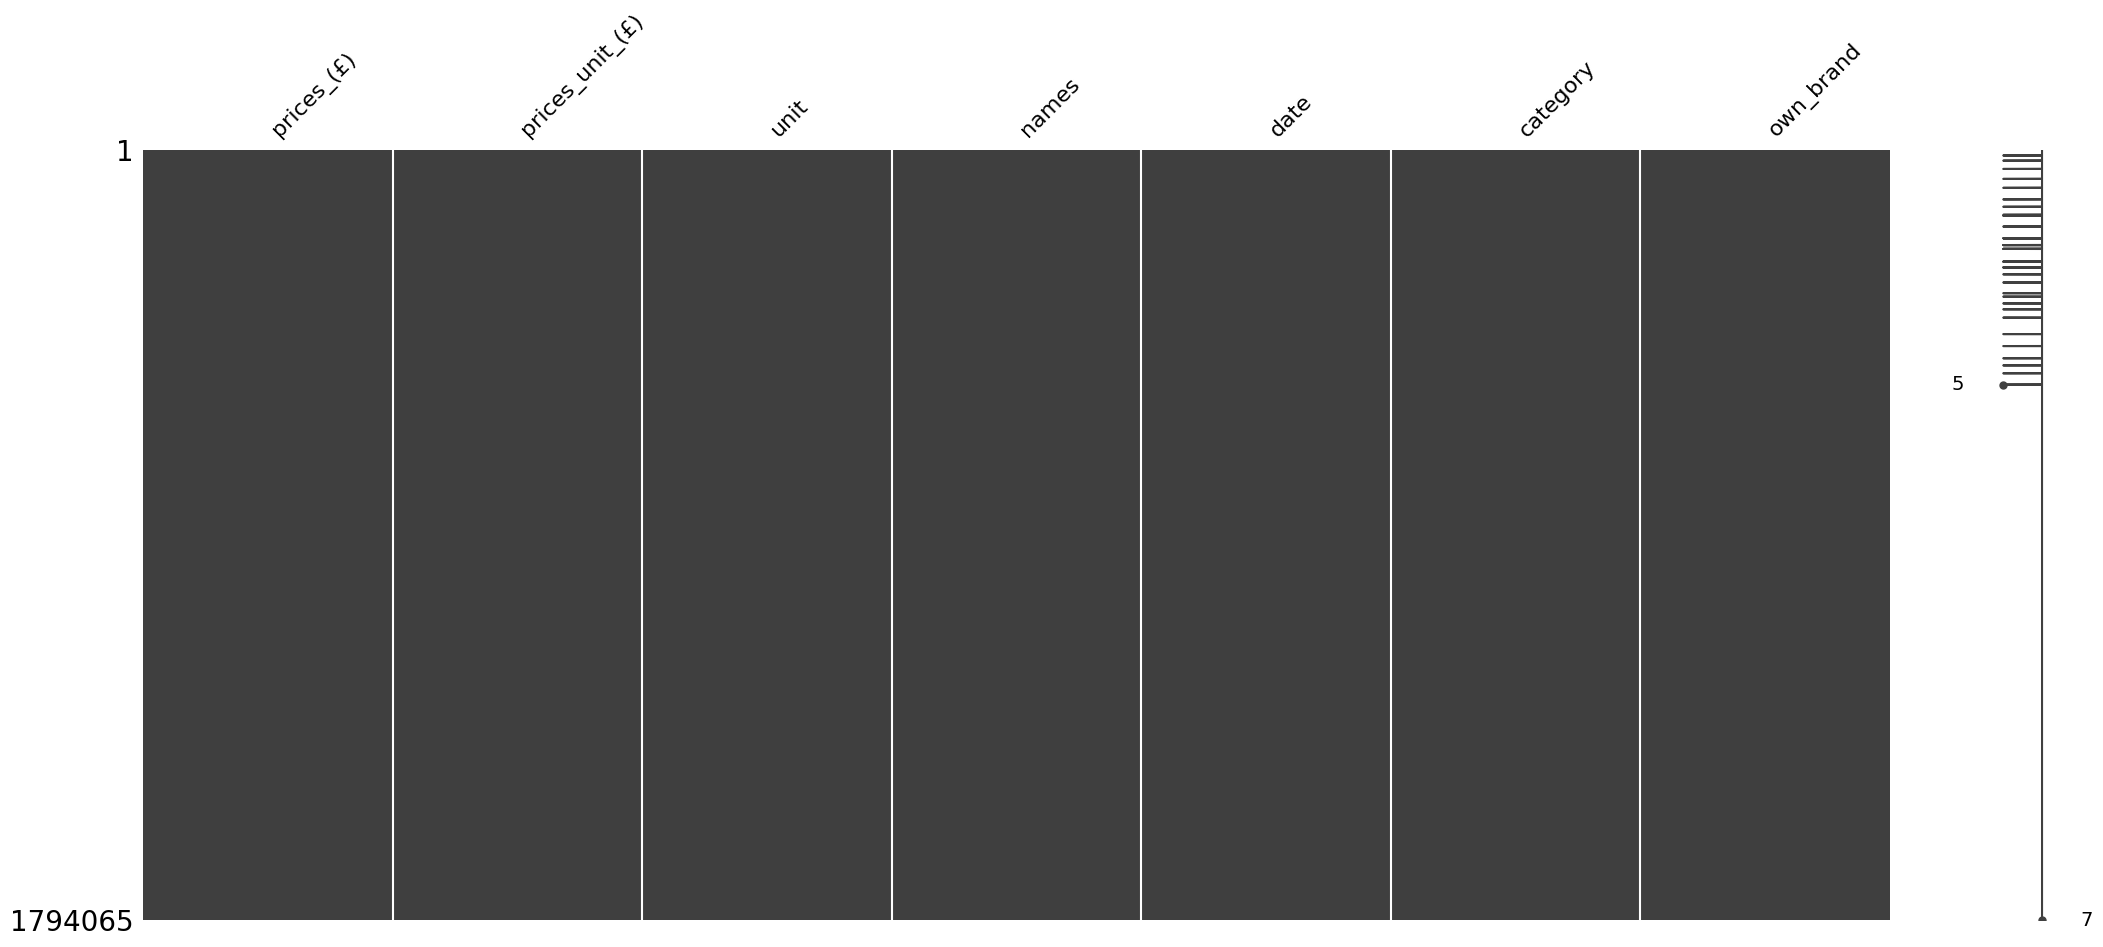

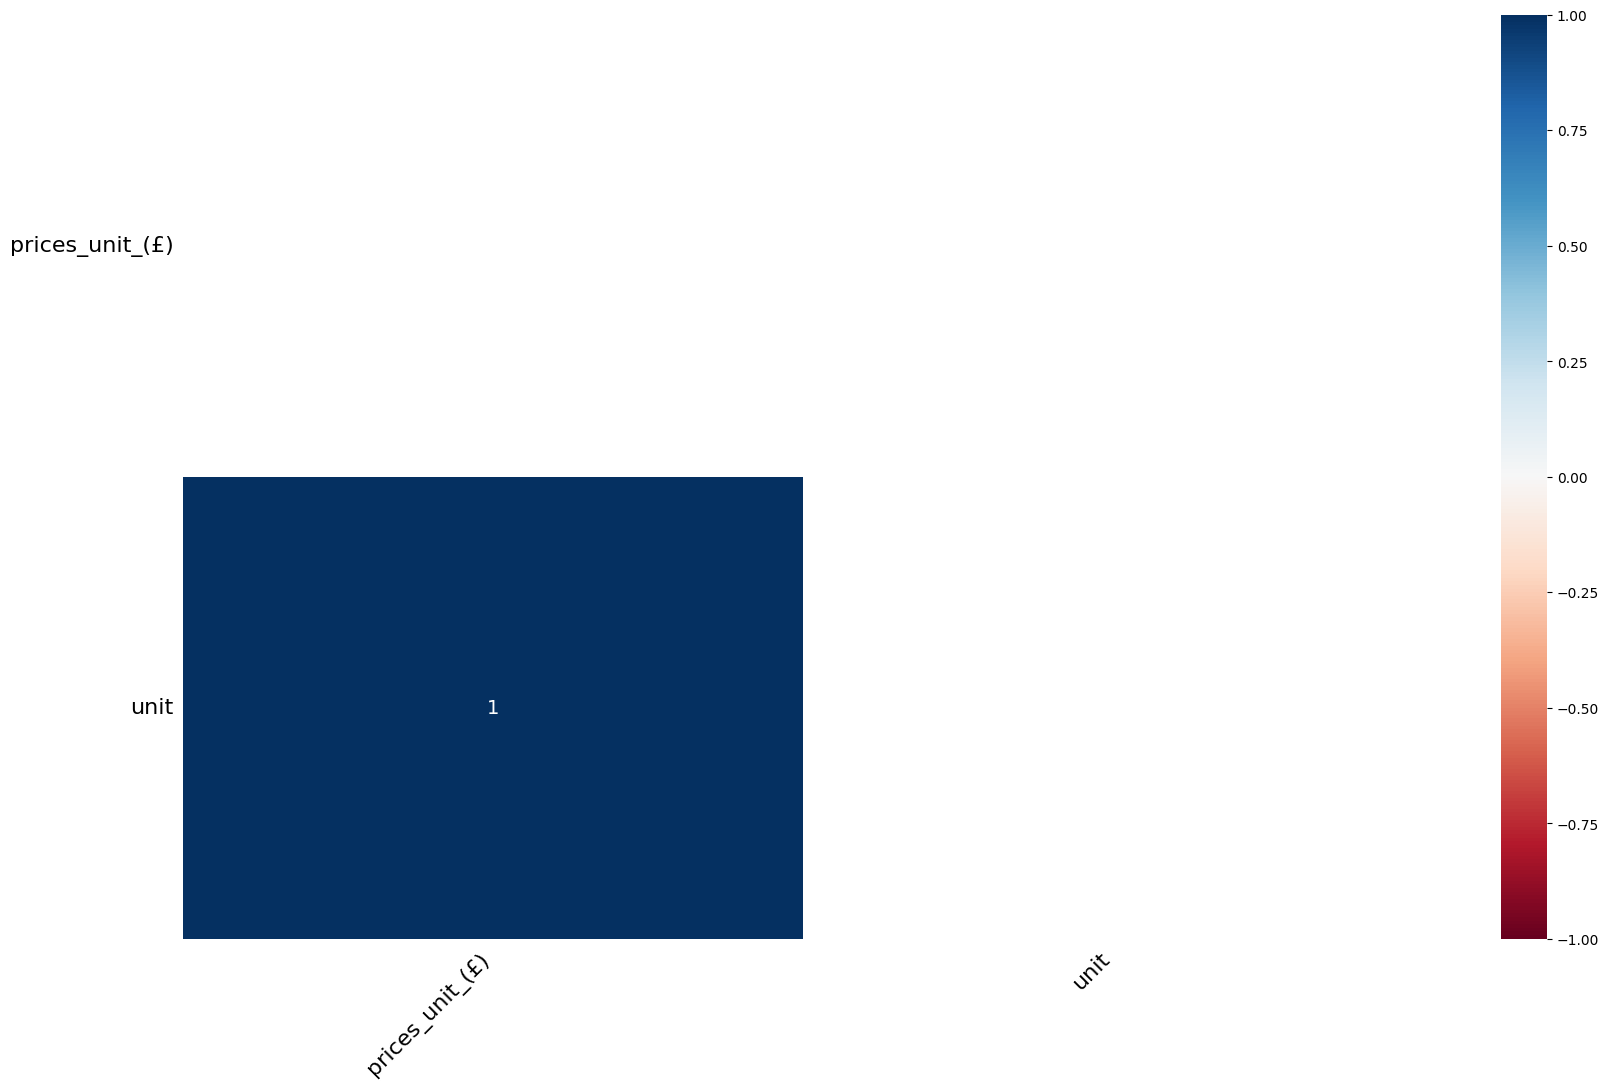

In [8]:
import missingno as msno
msno.matrix(df)
msno.heatmap(df)

In [9]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
prices_(£),1794065.0,4.894816,0.2,1.75,2.8,5.25,300.0,6.632725
prices_unit_(£),1793955.0,26.181018,0.0,3.3,7.4,14.95,11225.0,166.164239
date,1794065,2024-02-25 01:01:35.079497984,2024-01-09 00:00:00,2024-02-04 00:00:00,2024-02-24 00:00:00,2024-03-19 00:00:00,2024-04-13 00:00:00,NaN


In [10]:
df[df.select_dtypes(include='object').columns].nunique()

unit            4
names       26187
category       11
dtype: int64

In [11]:
df.duplicated().sum()

0

# Preprocessing

## Imputation

In [12]:
df = df.sort_values(['names', 'date']).reset_index(drop=True)

df['unit'] = df.groupby('names')['unit'].ffill().bfill()

df['prices_unit_(£)'] = df.groupby('names')['prices_unit_(£)'].ffill().bfill()

In [13]:
df.isna().sum()

prices_(£)         0
prices_unit_(£)    0
unit               0
names              0
date               0
category           0
own_brand          0
dtype: int64

## Feature Engineering

In [14]:
target = 'prices_unit_(£)'

### Lag/Rolling Features

In [15]:
for lag in [1,7,14]:
    df[f'lag_{lag}']  = df.groupby('names')[target].shift(lag)

for window in [7, 30]:
    df[f'roll_mean_{window}'] = (
        df.groupby('names')[target]
        .shift(1)
        .rolling(window, min_periods =1).mean()
    )
    df[f'roll_std_{window}'] = (
        df.groupby('names')[target]
        .shift(1)
        .rolling(window, min_periods =1).std()
    )

### Calendar Features

In [16]:
df['dayofweek']  = df['date'].dt.dayofweek
df['month']      = df['date'].dt.month
df['quarter']    = df['date'].dt.quarter
df['year']       = df['date'].dt.year
df['dayofmonth'] = df['date'].dt.day
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

In [17]:
print(df.columns)

Index(['prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date', 'category',
       'own_brand', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_7', 'roll_std_7',
       'roll_mean_30', 'roll_std_30', 'dayofweek', 'month', 'quarter', 'year',
       'dayofmonth', 'is_weekend'],
      dtype='object')


In [18]:
df.head

<bound method NDFrame.head of          prices_(£)  prices_unit_(£)  unit  \
0             12.98             6.49    kg   
1             12.98             6.49    kg   
2             12.98             6.49    kg   
3             12.98             6.49    kg   
4             12.97             6.49    kg   
...             ...              ...   ...   
1794060        2.25             0.11  unit   
1794061        2.25             0.11  unit   
1794062        2.25             0.11  unit   
1794063        2.25             0.11  unit   
1794064        2.25             0.11  unit   

                                           names       date         category  \
0               (CP) Morrisons Market St Britis… 2024-03-24       fresh_food   
1               (CP) Morrisons Market St Britis… 2024-03-25       fresh_food   
2               (CP) Morrisons Market St Britis… 2024-03-26       fresh_food   
3               (CP) Morrisons Market St Britis… 2024-03-27       fresh_food   
4               (

In [19]:
df = df.drop('prices_(£)', axis = 1)
df.columns

Index(['prices_unit_(£)', 'unit', 'names', 'date', 'category', 'own_brand',
       'lag_1', 'lag_7', 'lag_14', 'roll_mean_7', 'roll_std_7', 'roll_mean_30',
       'roll_std_30', 'dayofweek', 'month', 'quarter', 'year', 'dayofmonth',
       'is_weekend'],
      dtype='object')

In [20]:
df.isna().sum()

prices_unit_(£)         0
unit                    0
names                   0
date                    0
category                0
own_brand               0
lag_1               26187
lag_7              176391
lag_14             345869
roll_mean_7             3
roll_std_7              8
roll_mean_30            1
roll_std_30             2
dayofweek               0
month                   0
quarter                 0
year                    0
dayofmonth              0
is_weekend              0
dtype: int64

In [21]:
df = df.dropna().reset_index(drop=True)


# Train/Test Split

In [22]:

cutoff_date = df['date'].quantile(0.8)

train = df[df['date'] <= cutoff_date]
test  = df[df['date'] > cutoff_date]

features = [col for col in df.columns if col not in ['date', target]]
X_train, y_train = train[features], train[target]
X_test, y_test   = test[features], test[target]


In [23]:
for col in ['names', 'unit', 'category', 'own_brand']:
    X_train[col] = X_train[col].astype('category')
    X_test[col]  = X_test[col].astype('category')

# TransformedTargetRegressor

In [24]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

regressor = TransformedTargetRegressor(
    regressor=lgb_model,
    transformer=log_transformer
)

# TimeSeriesSplit Validation

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

rmse_list = []
mape_list = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    regressor.fit(X_tr, y_tr)

    y_pred = regressor.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    rmse_list.append(rmse)
    mape_list.append(mape)

    print(f"Fold {fold+1} — RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

print(f"\nAverage CV RMSE: {np.mean(rmse_list):.4f}")
print(f"Average CV MAPE: {np.mean(mape_list):.4f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5456
[LightGBM] [Info] Number of data points in the train set: 195723, number of used features: 15
[LightGBM] [Info] Start training from score 2.239109
Fold 1 — RMSE: 4.7923, MAPE: 46983202721.1401
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

# Hyperparameter tuning

In [26]:
param_grid = {
    'regressor__num_leaves': [31, 63],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__n_estimators': [200, 500],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Params from GridSearch:", grid.best_params_)

best_model = grid.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7252
[LightGBM] [Info] Number of data points in the train set: 293579, number of used features: 15
[LightGBM] [Info] Start training from score 2.220578
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31, regressor__subsample=1.0; total time=  21.7s
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For 

# Evaluation on Test Set

In [27]:
y_test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"\nTest RMSE: {test_rmse:.4f}, Test MAPE: {test_mape:.4f}")


Test RMSE: 10.4866, Test MAPE: 3057975132.0844


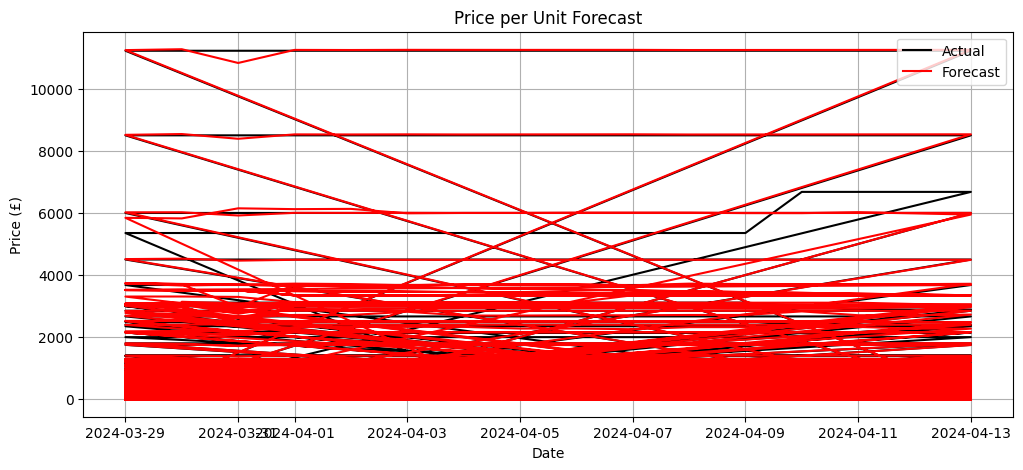

In [28]:

plt.figure(figsize=(12,5))

plt.plot(test['date'], y_test, label='Actual', color='black')
plt.plot(test['date'], y_test_pred, label='Forecast', color='red')

plt.title("Price per Unit Forecast")
plt.xlabel("Date")
plt.ylabel("Price (£)")
plt.legend()
plt.grid(True)  
plt.show()


In [29]:
import joblib
joblib.dump(best_model, '/kaggle/working/lightgbm_model.pkl')

['/kaggle/working/lightgbm_model.pkl']

In [31]:
results = test.copy()
results['y_true'] = y_test.values
results['y_test_pred'] = y_test_pred

print(results[['y_true', 'y_test_pred']].describe().T)

                count       mean         std       min       25%       50%  \
y_true       273883.0  29.543528  184.837602  0.000000  3.370000  7.950000   
y_test_pred  273883.0  29.450698  184.119003 -0.287805  3.376882  7.914338   

                   75%           max  
y_true       15.800000  11225.000000  
y_test_pred  15.748882  11274.339236  


In [33]:
def smape(y_true, y_test_pred):
    denominator = (np.abs(y_true) + np.abs(y_test_pred)) / 2
    diff = np.abs(y_true - y_test_pred) / denominator
    diff[denominator == 0] = 0
    return np.mean(diff) * 100

smape_val = smape(y_test, y_test_pred)
print(f"Test SMAPE: {smape_val:.2f}%")

Test SMAPE: 1.43%
